# Eurovision Network *Analysis*

***Start with imports and installation of needed libraries***

In [ ]:
%matplotlib inline
!pip install colorthief
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import sys
import os
from __future__ import division
plt.rcParams["figure.figsize"] = (40,20)
from itertools import chain
import tqdm as tqdm
from colorthief import ColorThief
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.vq import whiten
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
!unzip 'flags.zip'
from IPython.display import clear_output
clear_output()
import matplotlib.colors as mcolors
from networkx.classes.function import density
from collections import Counter

year = '2021' #'2019', '2018', '2017'

***Preprocessing function for 2021 dataset***

In [ ]:
def preprocessing_dataset(data):
  data = data.drop('index', axis = 1).T
  data["Total"] = data.sum(axis=1)
  data["Total"][4] = 9999 
  data = data.sort_values(by=['Total'], ascending=False).T
  data = data.rename({'Country (Voters (vertical), Finalists (horizontal))': 'ind'}, axis='columns')
  data = data.set_index('ind')
  data.rename({9999: 'Total'}, axis=0, inplace=True)
  data = data.T
  data = data.reset_index()
  data = data.rename({'index': 'Country'}, axis='columns')
  data = data.reset_index()
  data = data.rename({'index': 'Rank'}, axis='columns')
  return data

***A function that sorts the dictionary by couple***

In [ ]:
def orderpairs(a):  
    b = []
    for i in range(0, len(a)):
        maximum = 0
        for j in range(0, len(a)):
            if maximum <= a[j][1]:
                ind = j
                maximum = a[j][1]
        b.append(a.pop(ind))
    return b

***Function for percentage computation***

In [ ]:
def perc_dict(deg_tot, deg_slice):
    mean_dict = {}
    for nation in deg_slice.keys():
        if deg_tot[nation] > 0:
            mean_dict[nation] = deg_slice[nation]/deg_tot[nation]
        else:
            mean_dict[nation] = 0
    return mean_dict

***Funciton that generates colors***

In [ ]:
def RGB(red,green,blue): 
    return '#%02x%02x%02x' % (red,green,blue)

***Function that draws graphs involving positions***

In [ ]:
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=1250, cmap=plt.cm.plasma, 
                                   node_color=list(measures.values()),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1, base=10))
    labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

***If the flag is set to 2021, we import the two datasets and then we sum them up*** 

In [ ]:
if year == '2021':  
  votes_jury = pd.read_csv('Eurovision_juryvotes_2021.csv')
  votes_jury['Country (Voters (vertical), Finalists (horizontal))'] = ''
  votes_tele = pd.read_csv('Eurovision_televotes_2021.csv').sort_values(by=['Country (Voters (vertical), Finalists (horizontal))'], ascending=True).reset_index()
  votes_data = votes_jury + votes_tele
  votes_data = preprocessing_dataset(votes_data)
  df_copy = votes_data.copy()
  print('Maximum number of votes given to a single nation from each voting nation: ',
      df_copy.drop({'Rank','Country','Total'}, axis = 1).max().sort_values(ascending=False))

Maximum number of votes given to a single nation from each voting nation:  ind
Albania            24
Cyprus             24
Netherlands        24
Greece             24
North Macedonia    24
Lithuania          24
Spain              24
Ukraine            24
Croatia            22
Bulgaria           22
Slovenia           22
Serbia             22
San Marino         22
Germany            22
Austria            22
Moldova            22
Denmark            22
Australia          20
Russia             20
United Kingdom     20
Georgia            20
Belgium            20
Finland            20
Ireland            19
Estonia            19
Latvia             18
Israel             18
Azerbaijan         18
Switzerland        18
Romania            18
Portugal           18
Poland             18
Norway             18
Iceland            18
Italy              18
Sweden             17
France             16
Malta              16
Czechia            15
dtype: object


***DATA ANALYSIS - HOW THEY ARE RELIABLE*** ? 

***In the `votes_data` dataframe we have the information of number of points each country recieved from other countries. We'll tranform in into edge-list of votes with ``melt`` transformation. This procedure is done separately for 2019-18-17 datasets in 'Cleaning Eurovision.ipynb' notebook.***

In [ ]:
if year == '2021':
  votes_melted = votes_data.melt(
      ['Rank','Country','Total'],
      var_name = 'Source Country',value_name='points')
elif year == '2019':
  votes_melted = pd.read_csv('df_final_2019.csv')
elif year == '2018':
  votes_melted = pd.read_csv('df_final_2018.csv')
elif year == '2017':
  votes_melted = pd.read_csv('df_final_2017.csv')

# Drop self-assigned and standardize the vocabulary

votes_melted = votes_melted.drop(votes_melted[votes_melted['Source Country'] == votes_melted['Country']].index)
votes_melted['Country'] = votes_melted['Country'].replace(['The Netherlands'],'Netherlands') 
votes_melted['Source Country'] = votes_melted['Source Country'].replace(['The Netherands'],'Netherlands') 
votes_melted['Source Country'] = votes_melted['Source Country'].replace(['The Netherlands'],'Netherlands') 
votes_melted['Country'] = votes_melted['Country'].replace(['The Netherlands'],'Netherlands') 
votes_melted['Country'] = votes_melted['Country'].replace(['Czech Republic'],'Czechia') 
votes_melted['Source Country'] = votes_melted['Source Country'].replace(['Czech Republic'],'Czechia') 
votes_melted['Country'] = votes_melted['Country'].replace(['F.Y.R. Macedonia'],'Macedonia') 
votes_melted['Source Country'] = votes_melted['Source Country'].replace(['F.Y.R. Macedonia'],'Macedonia') 

***Now we have a very useful column called points, that is more handly. For this reason we start to deploy some quantitative analysis***

In [ ]:
print('HOW MANY TIMES A NATION GOT THE MAXIMUM POINTS:\n',
       votes_melted[votes_melted['points'] == 24]['Country'].value_counts())

print('\nHOW MANY TIMES A NATION GOT THE MINIMUM POINTS:\n',
      votes_melted[votes_melted['points'] == 0]['Country'].value_counts())

print('\nHOW MANY TIMES A NATION GIVES THE MAXIMUM POINTS:\n', 
      votes_melted[votes_melted['points'] == 24]['Source Country'].value_counts())

print('\nHOW MANY TIMES A NATION GIVES THE MINIMUM POINTS:\n', 
      votes_melted[votes_melted['points'] == 0]['Source Country'].value_counts())

HOW MANY TIMES A NATION GOT THE MAXIMUM POINTS:
 France         2
Switzerland    1
Greece         1
Cyprus         1
Ukraine        1
Serbia         1
Italy          1
Name: Country, dtype: int64

HOW MANY TIMES A NATION GOT THE MINIMUM POINTS:
 United Kingdom    38
Germany           36
Spain             36
Netherlands       33
Albania           29
San Marino        28
Moldova           25
Cyprus            25
Serbia            25
Belgium           21
Azerbaijan        20
Norway            19
Greece            19
Israel            18
Sweden            16
Portugal          14
Bulgaria          11
Russia             9
Lithuania          9
Iceland            7
Malta              2
Finland            1
Switzerland        1
Name: Country, dtype: int64

HOW MANY TIMES A NATION GIVES THE MAXIMUM POINTS:
 Albania            1
Cyprus             1
Greece             1
Lithuania          1
Netherlands        1
North Macedonia    1
Spain              1
Ukraine            1
Name: Source Country, d

#NETWORK METRICS


 ***By the 'points' column, we can define a clustering algortithm , basing on how countries are similar with respect to the given votes***

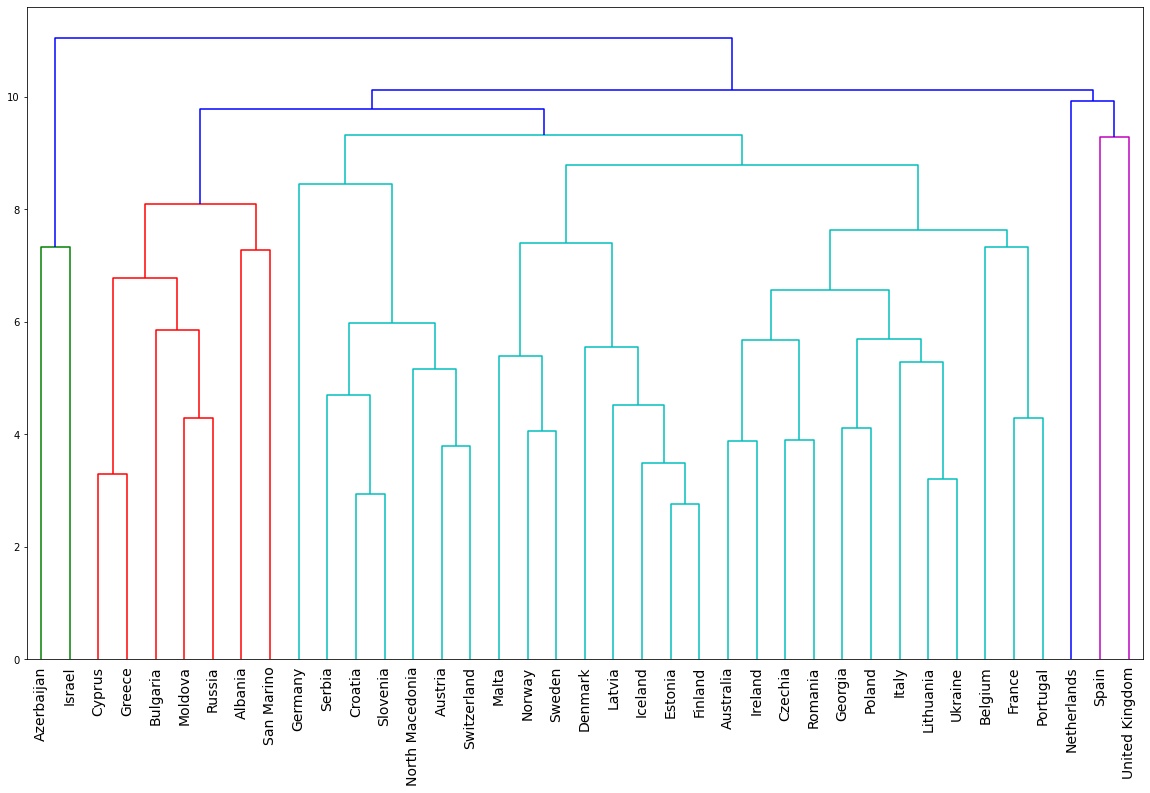

In [ ]:
df_points_to = votes_melted.drop('Total', axis = 1).set_index('Source Country').sort_values('points', ascending = False)
df_points_to = df_points_to.reset_index()
df_points_to = df_points_to.drop_duplicates()
dist = df_points_to.pivot(index='Source Country', columns='Country', values='points')
dist.fillna(24, inplace=True)
df_scaled = whiten(dist.to_numpy())
mergings = linkage(df_scaled, method='complete') #method = 'ward'
plt.figure(figsize=(20,12))
dn = dendrogram(mergings, labels=np.array(dist.index), color_threshold=9.7, leaf_rotation=90, leaf_font_size=14)

plt.show()

***Drop zero-values***

In [ ]:
votes_melted = votes_melted.drop(votes_melted[votes_melted['points'] == 0].index)
if year == '2021':
  votes_melted = votes_melted.drop('Rank', axis = 1)

***Let's build a directed, weighted ``networkx`` graph from the edgelist in ``votes_melted``:***

In [ ]:
G = nx.from_pandas_edgelist(votes_melted, 
                            source='Source Country',
                            target='Country',
                            edge_attr='points',
                            create_using=nx.DiGraph())

In [ ]:
nx.info(G)

'DiGraph with 39 nodes and 546 edges'

***Density measure, a value between 0 and 1***

In [ ]:
total_nodes = list(G.nodes())
if year == '2021':
  west_nodes = ['Italy', 'Spain', 'Portugal', 'France', 'Switzerland', 'Belgium', 'Germany', 'Netherlands', 'Greece', 'San Marino',  'Malta', 'Serbia']
elif year == '2019':
  west_nodes = ['Italy', 'Malta', 'Switzerland','North Macedonia', 'Slovenia', 'France', 'Serbia' , 'Albania', 'San Marino', 'Germany', 'Netherlands', 'Greece',   'Malta', 'Czechia'] 
elif year == '2018':
  west_nodes = ['Austria', 'Czechia', 'France', 'Germany', 'Hungary', 'Italy', 'Portugal', 'Serbia', 'Slovenia', 'Spain', 'Netherlands', 'Albania'] 
elif year == '2017':
  west_nodes = ['Austria', 'Belgium', 'Croatia', 'Denmark' , 'France', 'Germany', 'Greece' , 'Hungary', 'Italy', 'Poland' , 'Portugal', 'Spain', 'Netherlands', 'Albania']
  
voted_countries = list(votes_melted['Country'].unique())
voting_countries = list((Counter(total_nodes)-Counter(voted_countries)).elements())
tot_est_nodes = list(set(total_nodes).difference(set(west_nodes)))
tot_ovest_nodes = list(set(west_nodes).union(set(voting_countries)))

Gsub_east = G.subgraph(tot_est_nodes)
Gsub_west = G.subgraph(tot_ovest_nodes)

print('G Density: ', density(G) , '\n')
print('Gsub_west Density: ', density(Gsub_west), '\n')
print('Gsub_east Density: ' , density(Gsub_east))

G Density:  0.3684210526315789 

Gsub_west Density:  0.24461538461538462 

Gsub_east Density:  0.2962962962962963


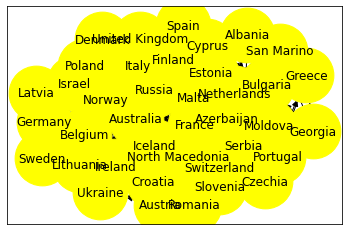

In [ ]:
nx.draw_networkx(G,node_size=3000,node_color = 'yellow')

***IN-DEGREE AND OUT-DEGREE ANALYSIS***

***Every country is giving the same amount of points (out degree):***

In [ ]:
out_deg_tot = dict(orderpairs(list(G.out_degree(weight='points'))))
print('ENTIRE GRAPH OUTPUT DEGREE:\n')
print(out_deg_tot)
print('\nENTIRE GRAPH INPUT DEGREE:\n')
in_deg_tot = dict(orderpairs(list(G.in_degree(weight='points'))))
print(in_deg_tot)

ENTIRE GRAPH OUTPUT DEGREE:

{'Czechia': 124, 'Australia': 122, 'Slovenia': 121, 'Cyprus': 118, 'Serbia': 118, 'France': 118, 'Switzerland': 117, 'United Kingdom': 116, 'Romania': 116, 'Poland': 116, 'North Macedonia': 116, 'Latvia': 116, 'Estonia': 116, 'Denmark': 116, 'Croatia': 116, 'Spain': 116, 'Belgium': 116, 'Israel': 116, 'Germany': 116, 'Portugal': 116, 'Austria': 116, 'Azerbaijan': 116, 'Norway': 116, 'Lithuania': 116, 'Iceland': 116, 'San Marino': 116, 'Sweden': 116, 'Bulgaria': 116, 'Greece': 116, 'Malta': 116, 'Finland': 116, 'Italy': 116, 'Ireland': 114, 'Netherlands': 114, 'Albania': 114, 'Ukraine': 113, 'Moldova': 112, 'Georgia': 111, 'Russia': 108}

ENTIRE GRAPH INPUT DEGREE:

{'Italy': 524, 'France': 499, 'Switzerland': 432, 'Iceland': 378, 'Ukraine': 364, 'Finland': 301, 'Malta': 255, 'Lithuania': 220, 'Russia': 204, 'Bulgaria': 170, 'Greece': 170, 'Portugal': 153, 'Moldova': 115, 'Sweden': 109, 'Serbia': 102, 'Cyprus': 94, 'Israel': 93, 'Norway': 75, 'Belgium': 74, 

In [ ]:
print('\nOUTPUT DEGREE east:\n')
out_deg_est = dict(orderpairs(list(Gsub_east.out_degree(weight='points'))))
print(out_deg_est)
print('\nINPUT DEGREE east:\n')
in_deg_east = dict(orderpairs(list(Gsub_east.in_degree(weight='points'))))
print(in_deg_east)

print('\nOUTPUT DEGREE west:\n')
out_deg_ovest = dict(orderpairs(list(Gsub_west.out_degree(weight='points'))))
print(out_deg_ovest)
print('\nINPUT DEGREE west:\n')
in_deg_west = dict(orderpairs(list(Gsub_west.in_degree(weight='points'))))
print(in_deg_west)


OUTPUT DEGREE east:

{'Denmark': 79, 'Latvia': 77, 'Azerbaijan': 71, 'Norway': 71, 'United Kingdom': 68, 'Estonia': 68, 'Finland': 67, 'Sweden': 65, 'Moldova': 63, 'Ireland': 62, 'Czechia': 62, 'Russia': 62, 'Israel': 59, 'Australia': 58, 'Poland': 55, 'Romania': 54, 'Iceland': 53, 'Lithuania': 51, 'Georgia': 46, 'Slovenia': 45, 'Croatia': 45, 'Ukraine': 45, 'North Macedonia': 44, 'Austria': 43, 'Cyprus': 43, 'Bulgaria': 42, 'Albania': 32}

INPUT DEGREE east:

{'Iceland': 272, 'Ukraine': 257, 'Finland': 207, 'Lithuania': 157, 'Russia': 141, 'Bulgaria': 111, 'Moldova': 77, 'Israel': 70, 'Sweden': 68, 'Norway': 61, 'Azerbaijan': 52, 'Cyprus': 39, 'Albania': 18, 'United Kingdom': 0, 'Slovenia': 0, 'Romania': 0, 'Poland': 0, 'North Macedonia': 0, 'Latvia': 0, 'Ireland': 0, 'Georgia': 0, 'Estonia': 0, 'Denmark': 0, 'Czechia': 0, 'Croatia': 0, 'Austria': 0, 'Australia': 0}

OUTPUT DEGREE west:

{'Slovenia': 76, 'Austria': 73, 'San Marino': 73, 'North Macedonia': 72, 'Croatia': 71, 'Spain': 

***Compute the percentage of votes between the two defined domains and extrapolate means in order to check the voting trends***


In [ ]:
perc_out_east_east = perc_dict(out_deg_tot, out_deg_est)
perc_out_west_west = perc_dict(out_deg_tot, out_deg_ovest)

mean_out_west = np.array(list(perc_out_west_west.items()))[:,1].astype(float)
mean_out_east = np.array(list(perc_out_east_east.items()))[:,1].astype(float)

print('OUTPUT DEGREE ANALYSYS (votes given):\n')
print('Percentage of votes: \nFrom west to west: ', np.mean(mean_out_west)*100, '%\nFrom west to east: ', (1-np.mean(mean_out_west))*100, '%\n')
print('Percentage of votes: \nFrom east to east: ',np.mean(mean_out_east)*100 , '%\nFrom east to west: ', (1-np.mean(mean_out_east))*100, '%\n')

perc_in_east_east = perc_dict(in_deg_tot, in_deg_east)
perc_in_west_west = perc_dict(in_deg_tot, in_deg_west)

mean_in_ovest = np.array(list(perc_in_west_west.items()))[:,1].astype(float)
mean_in_est = np.array(list(perc_in_east_east.items()))[:,1].astype(float)

print('INPUT DEGREE ANALYSYS (votes recived):\n')
print('Percentage of votes: \nFrom west to west: ', np.mean(mean_in_ovest)*100, '%\nFrom west to east: ', (1-np.mean(mean_in_ovest))*100, '%\n')
print('Percentage of votes: \nFrom east to east: ', np.mean(mean_in_est)*100  , '%\nFrom east to west: ',(1-np.mean(mean_in_est))*100, '%\n')

OUTPUT DEGREE ANALYSYS (votes given):

Percentage of votes: 
From west to west:  49.80565190623877 %
From west to east:  50.19434809376122 %

Percentage of votes: 
From east to east:  48.92457538407479 %
From east to west:  51.0754246159252 %

INPUT DEGREE ANALYSYS (votes recived):

Percentage of votes: 
From west to west:  32.14675969628837 %
From west to east:  67.85324030371163 %

Percentage of votes: 
From east to east:  31.70816797034884 %
From east to west:  68.29183202965116 %



#NODE METRICS

***First we import the 'countries.csv' dataset, in which there are useful information about the countries (as latitude and longitude for geographical positions)***

In [ ]:
countries = pd.read_csv('countries.csv',index_col='country')
pos_geo = { node: 
           ( max(-10,min(countries.loc[node]['longitude'],55)), # fixing scale
             max(countries.loc[node]['latitude'],25)) #fixing scale
               for node in G.nodes() }

We can analize the nodes with two approaches, considering their geographical positions or the Fruchterman positions

In [ ]:
flag_pos = pos_geo # set to pos_geo if you want geo positions

if flag_pos == 'fruchterman': 
  pos = nx.layout.fruchterman_reingold_layout(G,k=1,weight = 'points',iterations=1000,scale = 2)
else:
  pos = pos_geo

***Then we compute the centrality with many different approaches***

PAGE RANK

In [ ]:
#Fixing missing values in countries.csv 
pos['The Netherlands'] = pos['Netherlands'] 
pos['Czech Republic'] = pos['Czechia'] 
pos['Armenia'] = (40.177200, 44.503490)

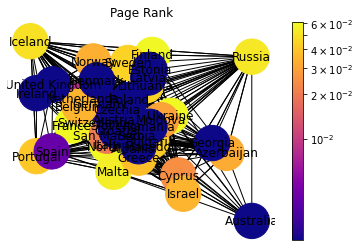

In [ ]:
page_rank = dict(nx.pagerank_numpy(G,weight = 'points'))
draw(G, pos , nx.pagerank_numpy(G), 'Page Rank')

BETWEENNESS CENTRALITY

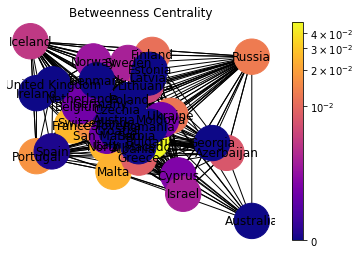

In [ ]:
between = dict(nx.betweenness_centrality(G,weight='points'))
draw(G, pos, nx.betweenness_centrality(G), 'Betweenness Centrality')

DEGREE CENTRALITY

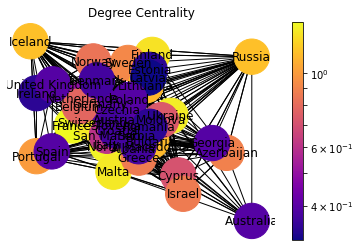

In [ ]:
degree_centrality = nx.degree_centrality(G)
draw(G, pos, nx.degree_centrality(G), 'Degree Centrality')

EIGENVECTOR CENTRALITY

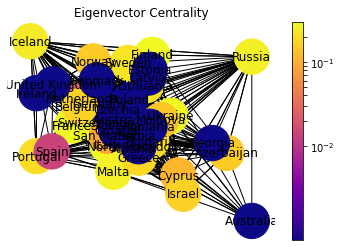

In [ ]:
eigen_centrality = nx.eigenvector_centrality(G)
draw(G, pos, nx.eigenvector_centrality(G), 'Eigenvector Centrality')

HUBS AND AUTHORITY CENTRALITY 

***A good hub represents a page that pointed to many other pages, while a good authority represents a page that is linked by many different hubs***

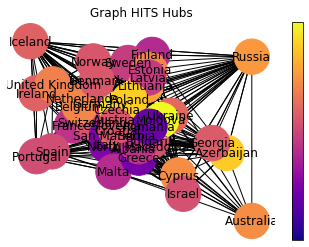

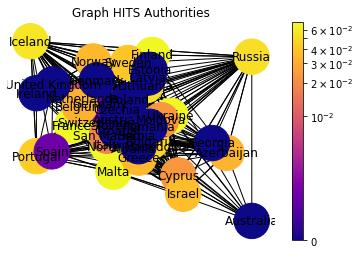

In [ ]:
h,a = nx.hits(G)
draw(G, pos, h, 'Graph HITS Hubs')
draw(G, pos, a, 'Graph HITS Authorities')

CLOSENESS CENTRALITY

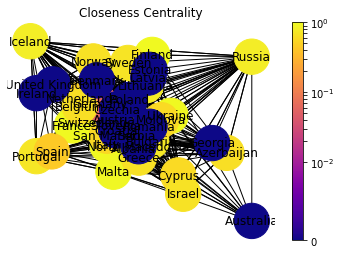

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
draw(G, pos, nx.closeness_centrality(G), 'Closeness Centrality')

***Let's assign to each coutry it's flag and position of the map***

In [ ]:
flags = {}
flag_color = {}
for node in tqdm.tqdm_notebook(G.nodes()):
    flags[node] = 'flags/'+(countries.loc[node]['country_code']).lower().replace(' ','')+'.png'   
    flag_color[node] =  ColorThief(flags[node]).get_color(quality=1)

  0%|          | 0/39 [00:00<?, ?it/s]

***Now we will draw the graph using flags as nodes and points as size (e.g. Italy is the biggest in 2021 edition)***

In [ ]:
ax=plt.gca()
fig=plt.gcf()
plt.axis('off')
plt.title('Eurovision Final Votes',fontsize = 24)

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform

tick_params = {'top':'off', 'bottom':'off', 'left':'off', 'right':'off',
              'labelleft':'off', 'labelbottom':'off'} #flag grid params

styles = ['dotted','dashdot','dashed','solid'] # line styles


    
# draw edges
for e in G.edges(data=True):
    width = e[2]['points']/24 #normalize by max points
    style=styles[int(width*3)]
    if width>0.3: #filter small votes
        nx.draw_networkx_edges(G,pos,edgelist=[e],width=width, style=style, edge_color = RGB(*flag_color[e[0]]) )
        # in networkx versions >2.1 arrowheads can be adjusted

#draw nodes    
for node in G.nodes():      
    imsize = max((0.3*G.in_degree(node,weight='points')
                  /max(dict(G.in_degree(weight='points')).values()))**2,0.03)
    
    # size is proportional to the votes
    flag = mpl.image.imread(flags[node])
    
    (x,y) = pos[node]
    xx,yy = trans((x,y)) # figure coordinates
    xa,ya = trans2((xx,yy)) # axes coordinates
    
    country = plt.axes([xa-imsize/2.0,ya-imsize/2.0, imsize, imsize ])
    country.imshow(flag)
    country.axis('off')
    country.set_aspect('equal')
    country.tick_params(**tick_params)
    
fig.savefig('eurovision_map.png')